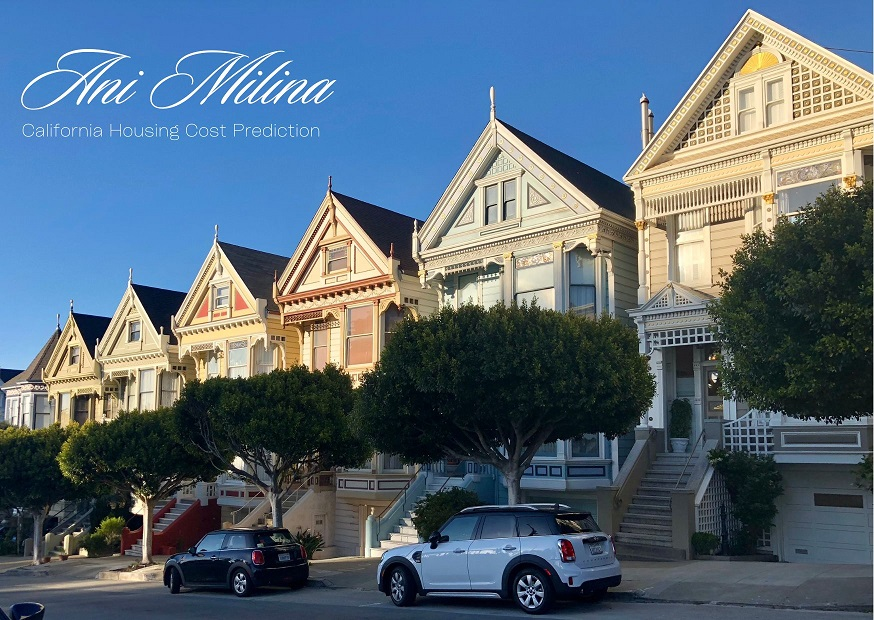

# Home value prediction

The project needs to train a linear regression model on California housing data in 1990. Based on the data, you need to predict the median cost of a house in a residential area. Train the model and make predictions on the test set. To assess the quality of the model, we use the RMSE, MAE and R2 metrics.

>**Dataset columns contain the following data:**  
>`longitude` - latitude  
>`latitude` - longitude  
>`housing_median_age` — median age of residents of the residential area  
>`total_rooms` - the total number of rooms in the houses of the residential area  
>`total_bedrooms` - the total number of bedrooms in the houses of the residential area  
>`population` - the number of people who live in the residential area  
>`households` - the number of households in the residential area  
>`median_income` — median income of residents of the residential area  
>`median_house_value` — median cost of a house in a residential area  
>`ocean_proximity` - proximity to the ocean  

>**Target feature `median_house_value`**


# Import libraries

In [1]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import pyspark
from pyspark.ml.feature import Imputer
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.ml.feature import QuantileDiscretizer, StringIndexer,StandardScaler, RobustScaler
from pyspark.ml.feature import PolynomialExpansion, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder as OHE_encoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator as OHE_encoder

In [2]:
spark = SparkSession.builder \
                    .master('local') \
                    .appName('California Housing – Price Regression') \
                    .getOrCreate()

# Settings

In [3]:
# Text styling

class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [4]:
# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [5]:
# Pandas default values

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [6]:
# Other

warnings.filterwarnings('ignore')

# Constants

In [7]:
CR = '\n'                                     # new line
RANDOM_STATE = RANDOM_SEED = RS = 66          # random_state
TEST_FRAC = 0.1                               # delayed sampling fraction

N_TRIALS = 10                                 # number of hyperparameter fitting attempts
N_CV = 4                                      # number of folds during cross validation
MAX_ITER = 1000                               # the maximum number of iterations for LinearRegression
DEGREE_POLYNOMIAL = 5                         # degree of polynomial expansion

# Data preparation

# Reading and checking data

In [10]:
data = spark.read.load('C:/Users/Admin/Desktop/DS studies/ПРОЕКТЫ/Dates/housing.csv', format="csv", sep=",", inferSchema=True, header="true")

In [11]:
 pd.DataFrame(data.dtypes, columns=['column', 'type'])

,column,type
0,_c0,int
1,longitude,double
2,latitude,double
3,housing_median_age,double
4,total_rooms,double
5,total_bedrooms,double
6,population,double
7,households,double
8,median_income,double
9,median_house_value,double


In [12]:
data.show(5)

+---+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|_c0|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  0|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  1|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  2|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  3|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  4| 

In [13]:
data.describe().toPandas().set_index('summary')

,_c0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
summary,,,,,,,,,,,
count,20640,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
mean,10319.5,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
stddev,5958.399113856003,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
min,0,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
max,20639,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


# Initial

# Drop features

In [14]:
# data = data.drop('index')
# data.sample(0.001).show(1)


# Missing values

In [15]:
columns = data.columns

for column in columns:
    check_col = F.col(column).isNull()
    print(column, data.filter(check_col).count())

_c0 0
longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


>There are missing values.
>
>We can replace them with mean or median values.

In [16]:
df_stats_before = data.describe().toPandas().set_index('summary').dropna(axis=1).astype('float')     # before change

In [17]:
data = (QuantileDiscretizer(
                            numBucketsArray=[10,10,10],
                            inputCols=['total_rooms','population','median_income'],
                            outputCols=['total_rooms_discrete','population_discrete','median_income_discrete'],
                            relativeError=0.01,
                            handleInvalid='error',
                           )
        .fit(data)
        .transform(data)
       )

In [18]:
data.select('total_rooms','total_rooms_discrete','population','population_discrete',
            'median_income','median_income_discrete').sample(0.001).show(5)

+-----------+--------------------+----------+-------------------+-------------+----------------------+
|total_rooms|total_rooms_discrete|population|population_discrete|median_income|median_income_discrete|
+-----------+--------------------+----------+-------------------+-------------+----------------------+
|     1050.0|                 1.0|     485.0|                0.0|       1.1607|                   0.0|
|     2636.0|                 6.0|    1142.0|                4.0|       2.1083|                   1.0|
|     1726.0|                 3.0|    1371.0|                6.0|       2.0335|                   1.0|
|     1436.0|                 2.0|    1005.0|                4.0|       3.4297|                   4.0|
|      880.0|                 0.0|     717.0|                1.0|       4.5469|                   7.0|
+-----------+--------------------+----------+-------------------+-------------+----------------------+
only showing top 5 rows



In [19]:
window = Window().partitionBy('total_rooms_discrete','population_discrete','median_income_discrete')

data = (data.withColumn('total_bedrooms',F.when(F.col('total_bedrooms').isNull(),F.avg(F.col('total_bedrooms')).over(window)).otherwise(F.col('total_bedrooms'))))

In [20]:
# Check the result

columns = data.columns

for column in columns:
    check_col = F.col(column).isNull()
    print(column, data.filter(check_col).count())

_c0 0
longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 1
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
total_rooms_discrete 0
population_discrete 0
median_income_discrete 0


>There is one missing value left. Perhaps this is just an outlier, and no matching group has been found for it.

In [21]:
med_value = int(data.approxQuantile('total_bedrooms', [0.5], 0)[0])
data = data.na.fill(value=med_value, subset=['total_bedrooms'])

In [22]:
# Check the result

columns = data.columns

for column in columns:
    check_col = F.col(column).isNull()
    print(column, data.filter(check_col).count())

_c0 0
longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0
total_rooms_discrete 0
population_discrete 0
median_income_discrete 0


# Removing temporary fields

In [23]:
data = data.drop('total_rooms_discrete','population_discrete','median_income_discrete')

# Correlation

In [24]:
# Check the correlation of features

data_drop = data.na.drop(subset='total_bedrooms')

# Converting to vector

vector_col = "corr_features"
drop_col = "ocean_proximity"
num_col = data_drop.drop("ocean_proximity").columns

assembler = VectorAssembler(
    inputCols=num_col, 
    outputCol=vector_col
)

df_vector = assembler.transform(data_drop).select(vector_col)

# Make a correlation matrix

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(
    data=corr_matrix, 
    columns = num_col, 
    index=num_col)

corr_matrix_df.style.background_gradient(cmap='ocean').set_precision(2)

,_c0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
_c0,1.00,-0.11,0.08,-0.18,0.06,0.03,0.02,0.03,0.07,0.07
longitude,-0.11,1.00,-0.92,-0.11,0.04,0.07,0.10,0.06,-0.02,-0.05
latitude,0.08,-0.92,1.00,0.01,-0.04,-0.07,-0.11,-0.07,-0.08,-0.14
housing_median_age,-0.18,-0.11,0.01,1.00,-0.36,-0.32,-0.30,-0.30,-0.12,0.11
total_rooms,0.06,0.04,-0.04,-0.36,1.00,0.93,0.86,0.92,0.20,0.13
total_bedrooms,0.03,0.07,-0.07,-0.32,0.93,1.00,0.88,0.98,-0.01,0.05
population,0.02,0.10,-0.11,-0.30,0.86,0.88,1.00,0.91,0.00,-0.02
households,0.03,0.06,-0.07,-0.30,0.92,0.98,0.91,1.00,0.01,0.07
median_income,0.07,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00,0.69
median_house_value,0.07,-0.05,-0.14,0.11,0.13,0.05,-0.02,0.07,0.69,1.00


**Suggested dependencies:**
>
> * total_bedrooms: more rooms - more bedrooms
> * population: more people - more bedrooms
> * households: more households - more rooms in them

# Compare statistics before and after filling in missing values

In [25]:
df_stats_after = data.describe().toPandas().set_index('summary').dropna(axis=1).astype('float')      # after change

In [26]:
# Difference in statistics before and after filling in missing values

df_chng = (df_stats_after - df_stats_before) / df_stats_before

df_chng.style.format('{:.3%}', na_rep='-').applymap(lambda value: 'color:red;' if abs(value) > 0.0001 else None)

,_c0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
summary,,,,,,,,,,
count,0.000%,0.000%,0.000%,0.000%,0.000%,1.013%,0.000%,0.000%,0.000%,0.000%
mean,0.000%,0.000%,0.000%,0.000%,0.000%,0.026%,0.000%,0.000%,-0.000%,0.000%
stddev,-0.000%,0.000%,0.000%,0.000%,-0.000%,-0.072%,0.000%,0.000%,0.000%,0.000%
min,-,-0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%
max,0.000%,-0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%


# Difference in statistics before and after filling in missing values

In [27]:
data = data.withColumn('rooms_div_population', F.col('total_rooms') / F.col('population'))

In [28]:
target = 'median_house_value'

In [29]:
# Create numeric and categorical lists

num_feature_list = []
cat_feature_list = []

for feature in data.dtypes:
    if feature[1] in ['double','float','int']:
        num_feature_list.append(feature[0])
    elif feature[1] in ['string']:
        cat_feature_list.append(feature[0])

num_feature_list = list(set(num_feature_list) - set([target]))     
cat_feature_list = list(set(cat_feature_list) - set([target]))     

In [30]:
num_feature_list

['households',
 'latitude',
 'total_bedrooms',
 'longitude',
 'median_income',
 'rooms_div_population',
 'total_rooms',
 '_c0',
 'housing_median_age',
 'population']

In [31]:
cat_feature_list

['ocean_proximity']


# Separate data for training and testing

# Categorical features

In [32]:
cat_indexer= StringIndexer(
                           inputCols=cat_feature_list,
                           outputCols=[f'{feature}_indexer' for feature in cat_feature_list]
                          )

In [33]:
ohe = OHE_encoder(
                  inputCols=[f'{feature}_indexer' for feature in cat_feature_list],
                  outputCols=[f'{feature}_ohe' for feature in cat_feature_list]
                 )

In [34]:
cat_assembler = VectorAssembler(
                                inputCols=[f'{feature}_ohe' for feature in cat_feature_list],
                                outputCol='cat_features_encoded'
                               )

# Numeric features

In [35]:
num_assembler = VectorAssembler(
                                inputCols=num_feature_list,
                                outputCol='num_features'
                               )

In [36]:
scaler = StandardScaler(
                        inputCol='num_features',
                        outputCol='num_features_scaled'
                       )

In [37]:
features_all =  VectorAssembler(inputCols=['cat_features_encoded','num_features_scaled'],
                               outputCol='features')

features_num =  VectorAssembler(inputCols=['num_features_scaled'],
                               outputCol='features')

In [38]:
lr = LinearRegression(labelCol="median_house_value", featuresCol="features")

# Training models

In [40]:
data_train, data_test = data.randomSplit([1-TEST_FRAC, TEST_FRAC], seed=RS)

print(f'''
Total Data
training:\t {data_train.count()}
test:\t {data_test.count()}
'''
) 

# use all features

stages_all = [cat_indexer, ohe, cat_assembler, num_assembler, scaler, features_all, lr]
pipeline_all = Pipeline(stages=stages_all)

stages_num = [num_assembler, scaler, features_num, lr]
pipeline_num = Pipeline(stages=stages_num)


Total Data
training:	 18558
test:	 2082



In [41]:
# train model

model_all = pipeline_all.fit(data_train)

predictions_all = model_all.transform(data_test)

predictedLabes = predictions_all.select("median_house_value", "prediction")

predictedLabes.show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          452600.0|403230.71259509446|
|          352100.0|376123.00720563764|
|          281500.0| 233997.4940131125|
|          104500.0| 143280.6483896668|
|          104200.0|149247.20220099343|
+------------------+------------------+
only showing top 5 rows



# Analysis of results

# Prediction

In [42]:
eval = RegressionEvaluator(labelCol = 'median_house_value')
rmse = eval.evaluate(predictions_all, {eval.metricName:'rmse'})
mae = eval.evaluate(predictions_all, {eval.metricName:'mae'})
r2 = eval.evaluate(predictions_all,{eval.metricName:'r2'})

print(f"""
Linear Regression Results Report for All Features
==================================
RMSE:\t {rmse}
MAE:\t {mae}
R2:\t {r2}
==================================
"""
)

# Create a dataframe to compare the results

d = {
    'Model': ['All features'],
    'RMSE': [rmse], 
    'MAE': [mae],
    'R2': [r2]
}
result_df = pd.DataFrame(data=d)
display(result_df.round(4))


Linear Regression Results Report for All Features
RMSE:	 66951.8022491807
MAE:	 48484.43002092027
R2:	 0.6690156524725573



,Model,RMSE,MAE,R2
0,All features,66951.802,48484.430,0.669


# Model based on numerical features

In [43]:
model_num = pipeline_num.fit(data_train)

predictions_num = model_num.transform(data_test)

predictedLabes = predictions_num.select("median_house_value", "prediction")

predictedLabes.show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          452600.0|404411.27926507825|
|          352100.0| 377335.2961909333|
|          281500.0|232187.02333138697|
|          104500.0| 139912.9247680013|
|          104200.0|146907.87186255772|
+------------------+------------------+
only showing top 5 rows



In [44]:
rmse = eval.evaluate(predictions_num, {eval.metricName:'rmse'})
mae = eval.evaluate(predictions_num, {eval.metricName:'mae'})
r2 = eval.evaluate(predictions_num,{eval.metricName:'r2'})

print(f"""
Linear Regression Results Report for All Features
==================================
RMSE:\t {rmse}
MAE:\t {mae}
R2:\t {r2}
==================================
"""
)

# Create a dataframe to compare the results

d = {
    'Model': ['All features'],
    'RMSE': [rmse], 
    'MAE': [mae],
    'R2': [r2]
}
result_df = pd.DataFrame(data=d)
display(result_df.round(4))


Linear Regression Results Report for All Features
RMSE:	 68092.68821796509
MAE:	 49771.14426583374
R2:	 0.6576393266605931



,Model,RMSE,MAE,R2
0,All features,68092.688,49771.144,0.658


In [45]:
spark.stop()

# Conclusion and recommendations

___________________________________________________________________________

# `Data validation`

A small number of missing values were found in the data provided, which were filled in with contextual medians.  

# `Preparing data for models`

The target variable and features are selected.  

A test sample was selected from the initial dataset for subsequent testing of the models.  

# `Result`

Trained two models:  

* on the full set of obtained features  

* on only numerical features  

Both models are stable. 

# `Recommendations and risks`

It is possible to conduct a full exploratory analysis. The main purpose of which is to choose the most suitable traits for learning. As an example, it can be noted that there are cutoff features in the input data: the target feature has a limit value of 500K.  